<a href="https://colab.research.google.com/github/Shirui-peng/Deep-Learning-in-Quantitative-Trading/blob/main/Chapter3/02_regress_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
project_dir = os.path.dirname(current_dir)
sys.path.append(project_dir)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# from Utilis.early_stopper import EarlyStopping

torch.manual_seed(42)
np.random.seed(42)

In [2]:
def train_model(model, X_train, y_train, X_val, y_val, X_test,
                savepath, epochs=5, lr=1e-3, batch_size=32, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=True)

    # early_stopper = EarlyStopping(savepath=savepath, patience=patience, min_delta=1e-4, verbose=True)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            out = model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)

        epoch_loss /= len(dataloader.dataset)
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val)
            val_loss = criterion(y_pred_val, y_val).item()

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train loss: {epoch_loss:.4f}, "
              f"Validation loss: {val_loss:.4f}")

        #early_stopper(model, val_loss)
        #if early_stopper.early_stop:
        #    print("Early stopping triggered!")
        #    break

    model.load_state_dict(torch.load(savepath))
    model.eval()
    y_pred_test = model(X_test)
    return model, y_pred_test

In [4]:
class MLP(nn.Module):
    def __init__(self, seq_length, n_features):
        super(MLP, self).__init__()
        self.flat_dim = seq_length * n_features
        self.net = nn.Sequential(
            nn.Flatten(),                   # (batch, seq_length*n_features)
            nn.Linear(self.flat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class CNN(nn.Module):
    def __init__(self, n_features, out_channels=32):
        super(CNN, self).__init__()
        # in_channels = n_features, kernel_size=3, padding=1
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=n_features,
                      out_channels=out_channels,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels,
                      kernel_size=3,
                      padding=1),
            nn.ReLU()
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc   = nn.Linear(out_channels, 1)

    def forward(self, x):
        # x: (batch, seq_length, n_features)
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.pool(x)        # shape: (batch, out_channels, 1)
        x = x.squeeze(-1)       # (batch, out_channels)
        x = self.fc(x)          # (batch,1)
        return x

class WaveNetLike(nn.Module):
    def __init__(self, n_features, out_channels=32,
                 kernel_size=2, dilation_depth=4):
        super(WaveNetLike, self).__init__()
        layers = []
        in_channels = n_features
        for d in range(dilation_depth):
            dilation_rate = 2 ** d
            padding = (kernel_size - 1) * dilation_rate
            conv = nn.Conv1d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                dilation=dilation_rate,
                padding=padding
            )
            layers.append(conv)
            in_channels = out_channels

        self.convs = nn.ModuleList(layers)
        self.activation = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc   = nn.Linear(out_channels, 1)

    def forward(self, x):
        # x: (batch, seq_length, n_features)
        x = x.permute(0, 2, 1)  # (batch, n_features, seq_length)

        for conv in self.convs:
            x = conv(x)
            x = self.activation(x)

        x = self.pool(x)        # (batch, out_channels, 1)
        x = x.squeeze(-1)       # (batch, out_channels)
        x = self.fc(x)          # (batch,1)
        return x

class LSTMModel(nn.Module):
    def __init__(self, n_features, hidden_size=64):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        # x: (batch, seq_length, n_features)
        output, (h_n, c_n) = self.lstm(x)
        # output: (batch, seq_length, hidden_size)
        last_output = output[:, -1, :]  # (batch, hidden_size)
        return self.fc(last_output)

class TransformerModel(nn.Module):
    def __init__(self, seq_length, n_features, d_model=64, nhead=4, num_layers=2):
        super(TransformerModel, self).__init__()
        self.d_model = d_model

        self.input_fc = nn.Linear(n_features, d_model)
        self.pos_embedding = nn.Parameter(
            torch.randn(1, seq_length, d_model)
        )

        # TransformerEncoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=128,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (batch, seq_length, n_features)
        x = self.input_fc(x)  # (batch, seq_length, d_model)

        seq_len = x.size(1)
        x = x + self.pos_embedding[:, :seq_len, :]
        x = self.transformer_encoder(x)  # (batch, seq_length, d_model)

        # Global Average Pooling over seq_length
        x = x.permute(0, 2, 1)
        x = self.pool(x)  # (batch, d_model, 1)
        x = x.squeeze(-1) # (batch, d_model)

        x = self.fc(x)    # (batch, 1)
        return x

In [5]:
# Simiulate some data to perform a regression problem.
# The x inputs have dimension of (batch_samples, time look-back windows, feature numbers).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
N = 2000
seq_length = 20
n_features = 3

# X: (N, seq_length, n_features)
X_np = np.random.randn(N, seq_length, n_features)
noise = 0.1 * np.random.randn(N)
y_np = 2 * X_np[:, -1, 0] + 3 * X_np[:, -1, 1] - 1.5 * X_np[:, -1, 2] + noise
y_np = y_np.reshape(-1, 1)  # shape (N,1)

split_index_val = int(N * 0.6)
split_index_test = int(N * 0.8)

X_train_np = X_np[:split_index_val]
y_train_np = y_np[:split_index_val]
X_val_np = X_np[split_index_val:split_index_test]
y_val_np = y_np[split_index_val:split_index_test]
X_test_np  = X_np[split_index_test:]
y_test_np  = y_np[split_index_test:]

X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val_np, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32).to(device)

print("Train X shape:", X_train.shape)
print("Train y shape:", y_train.shape)
print("Val X shape:", X_val.shape)
print("Val y shape:", y_val.shape)
print("Test  X shape:", X_test.shape)
print("Test  y shape:", y_test.shape)

Using device: cpu
Train X shape: torch.Size([1200, 20, 3])
Train y shape: torch.Size([1200, 1])
Val X shape: torch.Size([400, 20, 3])
Val y shape: torch.Size([400, 1])
Test  X shape: torch.Size([400, 20, 3])
Test  y shape: torch.Size([400, 1])


In [11]:
mlp_model = MLP(seq_length, n_features).to(device)
mlp_model, y_pred_mlp = train_model(mlp_model, X_train, y_train, X_val, y_val, X_test, epochs=40, savepath=current_dir + '/model/best_mlp')

Epoch 1/40, Train loss: 15.5887, Validation loss: 13.7427
Epoch 2/40, Train loss: 12.5010, Validation loss: 9.1605
Epoch 3/40, Train loss: 5.2849, Validation loss: 2.2297
Epoch 4/40, Train loss: 0.8310, Validation loss: 0.5055
Epoch 5/40, Train loss: 0.3687, Validation loss: 0.4070
Epoch 6/40, Train loss: 0.2486, Validation loss: 0.3365
Epoch 7/40, Train loss: 0.1796, Validation loss: 0.3065
Epoch 8/40, Train loss: 0.1398, Validation loss: 0.2705
Epoch 9/40, Train loss: 0.1111, Validation loss: 0.2602
Epoch 10/40, Train loss: 0.0904, Validation loss: 0.2481
Epoch 11/40, Train loss: 0.0774, Validation loss: 0.2378
Epoch 12/40, Train loss: 0.0654, Validation loss: 0.2348
Epoch 13/40, Train loss: 0.0544, Validation loss: 0.2167
Epoch 14/40, Train loss: 0.0470, Validation loss: 0.2192
Epoch 15/40, Train loss: 0.0399, Validation loss: 0.2152
Epoch 16/40, Train loss: 0.0350, Validation loss: 0.2120
Epoch 17/40, Train loss: 0.0325, Validation loss: 0.2064
Epoch 18/40, Train loss: 0.0269, Vali

In [12]:
cnn_model = CNN(n_features=3).to(device)
cnn_model, y_pred_cnn = train_model(cnn_model, X_train, y_train, X_val, y_val, X_test, epochs=40, savepath='model/best_cnn')

Epoch 1/40, Train loss: 16.1403, Validation loss: 15.0351
Epoch 2/40, Train loss: 16.0286, Validation loss: 14.9053
Epoch 3/40, Train loss: 15.9018, Validation loss: 14.6934
Epoch 4/40, Train loss: 15.7193, Validation loss: 14.4897
Epoch 5/40, Train loss: 15.5104, Validation loss: 14.2428
Epoch 6/40, Train loss: 15.2572, Validation loss: 13.9731
Epoch 7/40, Train loss: 15.0103, Validation loss: 13.8807
Epoch 8/40, Train loss: 14.7104, Validation loss: 13.4722
Epoch 9/40, Train loss: 14.3657, Validation loss: 13.0142
Epoch 10/40, Train loss: 14.1118, Validation loss: 12.8900
Epoch 11/40, Train loss: 13.5543, Validation loss: 12.4431
Epoch 12/40, Train loss: 13.0030, Validation loss: 12.0992
Epoch 13/40, Train loss: 12.5696, Validation loss: 11.4002
Epoch 14/40, Train loss: 11.9068, Validation loss: 10.9709
Epoch 15/40, Train loss: 11.2853, Validation loss: 10.2679
Epoch 16/40, Train loss: 10.5390, Validation loss: 9.7065
Epoch 17/40, Train loss: 9.8667, Validation loss: 9.1542
Epoch 18/

In [13]:
wavenet_model = WaveNetLike(n_features=3).to(device)
wavenet_model, y_pred_wavenet = train_model(wavenet_model, X_train, y_train, X_val, y_val, X_test, epochs=40, savepath='model/best_wavenet')

Epoch 1/40, Train loss: 16.1315, Validation loss: 15.1100
Epoch 2/40, Train loss: 16.1022, Validation loss: 15.0477
Epoch 3/40, Train loss: 15.9323, Validation loss: 14.6704
Epoch 4/40, Train loss: 15.1386, Validation loss: 13.1479
Epoch 5/40, Train loss: 13.4597, Validation loss: 11.0158
Epoch 6/40, Train loss: 10.9771, Validation loss: 7.6059
Epoch 7/40, Train loss: 6.8349, Validation loss: 4.1092
Epoch 8/40, Train loss: 3.7509, Validation loss: 2.0693
Epoch 9/40, Train loss: 2.2314, Validation loss: 1.5599
Epoch 10/40, Train loss: 1.5585, Validation loss: 1.1319
Epoch 11/40, Train loss: 1.2259, Validation loss: 0.8337
Epoch 12/40, Train loss: 0.9616, Validation loss: 0.9282
Epoch 13/40, Train loss: 0.7846, Validation loss: 0.5610
Epoch 14/40, Train loss: 0.6256, Validation loss: 0.4709
Epoch 15/40, Train loss: 0.5465, Validation loss: 0.4362
Epoch 16/40, Train loss: 0.4600, Validation loss: 0.5804
Epoch 17/40, Train loss: 0.4072, Validation loss: 0.2977
Epoch 18/40, Train loss: 0.34

In [14]:
lstm_model = LSTMModel(n_features=3).to(device)
lstm_model, y_pred_lstm = train_model(lstm_model, X_train, y_train, X_val, y_val, X_test, epochs=26, savepath='model/best_lstm')

Epoch 1/26, Train loss: 15.7517, Validation loss: 13.9800
Epoch 2/26, Train loss: 11.7293, Validation loss: 6.2908
Epoch 3/26, Train loss: 2.9486, Validation loss: 0.4760
Epoch 4/26, Train loss: 0.2961, Validation loss: 0.0885
Epoch 5/26, Train loss: 0.1173, Validation loss: 0.0556
Epoch 6/26, Train loss: 0.0762, Validation loss: 0.0346
Epoch 7/26, Train loss: 0.0558, Validation loss: 0.0247
Epoch 8/26, Train loss: 0.0410, Validation loss: 0.0234
Epoch 9/26, Train loss: 0.0350, Validation loss: 0.0188
Epoch 10/26, Train loss: 0.0279, Validation loss: 0.0182
Epoch 11/26, Train loss: 0.0250, Validation loss: 0.0167
Epoch 12/26, Train loss: 0.0220, Validation loss: 0.0178
Epoch 13/26, Train loss: 0.0219, Validation loss: 0.0150
Epoch 14/26, Train loss: 0.0173, Validation loss: 0.0160
Epoch 15/26, Train loss: 0.0168, Validation loss: 0.0148
Epoch 16/26, Train loss: 0.0173, Validation loss: 0.0135
Epoch 17/26, Train loss: 0.0177, Validation loss: 0.0153
Epoch 18/26, Train loss: 0.0185, Vali

In [15]:
transformer_model = TransformerModel(seq_length, n_features).to(device)
transformer_model, y_pred_transformer = train_model(transformer_model, X_train, y_train, X_val, y_val, X_test, epochs=17, savepath='model/best_transformer')

Epoch 1/17, Train loss: 14.3914, Validation loss: 4.2734
Epoch 2/17, Train loss: 2.2277, Validation loss: 1.0233
Epoch 3/17, Train loss: 0.8500, Validation loss: 0.2048
Epoch 4/17, Train loss: 0.3739, Validation loss: 0.1202
Epoch 5/17, Train loss: 0.2456, Validation loss: 0.0966
Epoch 6/17, Train loss: 0.1941, Validation loss: 0.0875
Epoch 7/17, Train loss: 0.1552, Validation loss: 0.0387
Epoch 8/17, Train loss: 0.1337, Validation loss: 0.0349
Epoch 9/17, Train loss: 0.0980, Validation loss: 0.0394
Epoch 10/17, Train loss: 0.1098, Validation loss: 0.0969
Epoch 11/17, Train loss: 0.0885, Validation loss: 0.0505
Epoch 12/17, Train loss: 0.0704, Validation loss: 0.0484
Epoch 13/17, Train loss: 0.0698, Validation loss: 0.0236
Epoch 14/17, Train loss: 0.0888, Validation loss: 0.0377
Epoch 15/17, Train loss: 0.0651, Validation loss: 0.0437
Epoch 16/17, Train loss: 0.0521, Validation loss: 0.0258
Epoch 17/17, Train loss: 0.0534, Validation loss: 0.0211


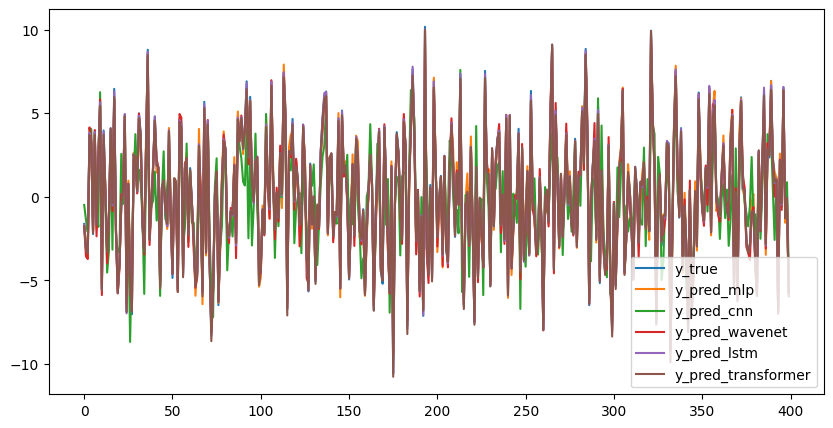

In [16]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label='y_true')
plt.plot(y_pred_mlp.detach().numpy(), label='y_pred_mlp')
plt.plot(y_pred_cnn.detach().numpy(), label='y_pred_cnn')
plt.plot(y_pred_wavenet.detach().numpy(), label='y_pred_wavenet')
plt.plot(y_pred_lstm.detach().numpy(), label='y_pred_lstm')
plt.plot(y_pred_transformer.detach().numpy(), label='y_pred_transformer')
plt.legend()